<a href="https://colab.research.google.com/github/AlexDima17/Architectural_components_with_GANs/blob/master/meshConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

##  Install and Import modules

If `torch`, `torchvision` and `pytorch3d` are not installed, run the following cell:

In [2]:
#!pip install torch torchvision
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-eecfxb12
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-eecfxb12
  Running command git checkout -q 686c8666d31d932ed42d3cd7319f249fc75e89a9
     |████████████████████████████████| 276kB 9.7MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.2.0-cp36-cp36m-linux_x86_64.whl size=11082094 sha256=780cbca04fa4f7cf23a220efdcec97256f82d5efe686686736b7402a99544925
  Stored in directory: /tmp/pip-ephem-wheel-cache-gansf22s/wheels/89/69/08/d864f516508b5d943259c6088baa150ebdd3659b5dde4e3571
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200618-cp36-none-any.whl size=41036 sha256=0aa62f1215d2778ebd3c5281dd3c290bb07214ff32a82d75a19c9adfb555d2e2
  Stored in directory: /root/.cache/pip/wheels/1f/54/b5/a58a2123544e1a3dd911612757b48ad2c8f2c65b411d34f9a6
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size

In [3]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm import tqdm_notebook
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80


In [11]:
import pytorch3d

In [4]:
if torch.cuda.is_available(): 
  print('available')
  device = torch.device("cuda:0")

available



**Load the objects**

In [5]:
from google.colab import files

In [6]:
uploaded = files.upload()

Saving Rabbit_Lowpoly_1.obj to Rabbit_Lowpoly_1.obj


In [7]:
# Load the rabbit obj.
rabbit_obj = os.path.join('Rabbit_Lowpoly_1.obj')

In [8]:
# Read the rabbit 3D model using load_obj
#verts is a (v,3)-tensor and faces is a (F,3)-tensor
verts, faces, aux = load_obj(rabbit_obj)
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
rabbit_mesh = Meshes(verts=[verts], faces=[faces_idx])

/usr/local/lib/python3.6/dist-packages/pytorch3d/io/obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


In [ ]:
print(faces_idx)

tensor([[  0,  40,  85],
        [ 40,  39,  85],
        [  1,  41,   0],
        ...,
        [217,   6,   7],
        [119, 217, 216],
        [216, 217,   7]], device='cuda:0')


In [52]:
# An initial mesh ("random noise")
src_mesh = ico_sphere(5, device)

In [74]:
sph=ico_sphere(5, device)

In [ ]:
import scipy.io as io
voxels = io.loadmat("piano_000000036_7")['instance']
voxels

In [ ]:
import numpy as np
voxels = np.pad(voxels, (1, 1), 'constant', constant_values=(0, 0))
voxels

In [ ]:
vox=torch.from_numpy(voxels) 
#vox=torch.reshape(vox,(4,17,68,68)) #reshape to 4 rank tensor
vox

In [ ]:
import scipy.ndimage as nd
voxels = nd.zoom(voxels, (2, 2, 2), mode='constant', order=0)

###  Visualize the source and target meshes

In [ ]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [ ]:
# %matplotlib notebook
plot_pointcloud(trg_mesh, "Target mesh")
plot_pointcloud(src_mesh, "Source mesh")

NameError: ignored

## Make a model


In [61]:
vox=torch.randn((4,4,4,4)) #a random grid of voxels
vox=vox.to('cuda')
vox.device

device(type='cuda', index=0)

In [62]:
#hmmm so I probably need voxels to use these?

cubifier=pytorch3d.ops.cubify(vox,0.1,device)
v,f=cubifier.get_mesh_verts_faces(0)
print(v)
cubifier.device

tensor([[-1.0000, -1.0000,  1.0000],
        [-1.0000, -1.0000,  1.6667],
        [-0.3333, -1.0000, -1.0000],
        [-0.3333, -1.0000, -0.3333],
        [-0.3333, -1.0000,  0.3333],
        [-0.3333, -1.0000,  1.0000],
        [-0.3333, -1.0000,  1.6667],
        [ 0.3333, -1.0000, -1.0000],
        [ 0.3333, -1.0000, -0.3333],
        [ 0.3333, -1.0000,  0.3333],
        [ 1.0000, -1.0000, -1.0000],
        [ 1.0000, -1.0000, -0.3333],
        [ 1.0000, -1.0000,  0.3333],
        [ 1.0000, -1.0000,  1.0000],
        [ 1.0000, -1.0000,  1.6667],
        [ 1.6667, -1.0000,  0.3333],
        [ 1.6667, -1.0000,  1.0000],
        [ 1.6667, -1.0000,  1.6667],
        [-1.0000, -0.3333, -0.3333],
        [-1.0000, -0.3333,  0.3333],
        [-1.0000, -0.3333,  1.0000],
        [-1.0000, -0.3333,  1.6667],
        [-0.3333, -0.3333, -1.0000],
        [-0.3333, -0.3333, -0.3333],
        [-0.3333, -0.3333,  0.3333],
        [-0.3333, -0.3333,  1.0000],
        [-0.3333, -0.3333,  1.6667],
 

device(type='cuda', index=0)

In [13]:
# Fetch the verts and faces of the final predicted mesh
final_verts2, final_faces2 = cubifier.get_mesh_verts_faces(0)

# Store the predicted mesh using save_obj
final_obj2 = os.path.join('./', 'exp_model2.obj')
save_obj(final_obj2, final_verts2, final_faces2)

In [ ]:
files.download('exp_model2.obj')

##model

In [ ]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)
z = torch.randn(10,2)

print(x)
print(z)
#a sequential model 
model = torch.nn.Sequential(
    pytorch3d.ops.GraphConv(D_in, 2,directed=False),   
    #torch.nn.Linear(D_in, H), 
    torch.nn.ReLU(),
    pytorch3d.ops.GraphConv(2, D_out)
    #torch.nn.Linear(H, D_out)    
)
print(model)
print(pytorch3d.ops.GraphConv(D_in, H))
#loss_fn = torch.nn.MSELoss(reduction='sum')


learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for t in range(500):
  
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

In [ ]:
y_pred = GraphConv(x,z)
print(y_pred)

GraphConv(1 -> 3, directed=False)


## 3. Optimization loop 

In [63]:
src_mesh = cubifier

In [64]:
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device= device, requires_grad=True)

In [65]:
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [ ]:
# change optimizer
optimizer = torch.optim.Adam([deform_verts], lr=1.0)

In [77]:
# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 250
loop = tqdm_notebook(range(Niter))

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

%matplotlib inline

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(rabbit_mesh, 5000) 
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    sample_src = sample_src.reshape((1,4*5000,3))
    
    #chamfer loss between point clouds
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer

    ########check tensor shapes
    #samplesph = sample_points_from_meshes(sph, 5000) 
    #print(sample_trg.shape)
    #print(sample_src.shape)
    #print(samplesph.shape)

    # torch.Size([1, 5000, 3])
    # torch.Size([4, 5000, 3]) why?
    ###########################

        # Optimization step
    loss.backward()
    optimizer.step()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


## 4. Visualize the loss

Text(0.5, 1.0, 'Loss vs iterations')

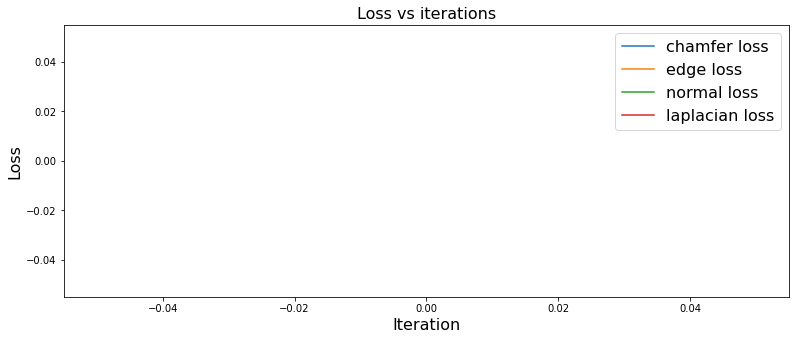

In [78]:
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")

## 5. Save the predicted mesh

In [79]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = os.path.join('./', 'exp_model1.obj')
save_obj(final_obj, final_verts, final_faces)

In [80]:
files.download('exp_model1.obj')
#files.download('exp_model2.obj')

## 6. Conclusion 

In this tutorial we learnt how to load a mesh from an obj file, initialize a PyTorch3D datastructure called **Meshes**, set up an optimization loop and use four different PyTorch3D mesh loss functions. 